In [ ]:
#See README file to see where code is sourced from.

In [29]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
#from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D, Dropout
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras.applications.resnet50 import preprocess_input
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import scipy
import random
import gc
import glob
from keras.utils.vis_utils import plot_model


In [30]:
#Read in CSV file for FER2013 data to be manipulated.
data = pd.read_csv('/com.docker.devenvironments.code/fer2013/icml_face_data.csv')

In [31]:
#Define which CSV data is image data and which is label data.
pixel_data = data[' pixels']
label_data = data['emotion']

In [32]:
#Print number of images that can be generated from CSV data. 
len(label_data)

35887

In [33]:
#Pre-process the CSV data and reshape it into a 48x48 image.
def preprocess_pixels(pixel_data):
  images = []
  for i in range(len(pixel_data)):
    img = np.fromstring(pixel_data[i], dtype='int', sep=' ')
    img = img.reshape(48,48,1)
    images.append(img)

  X = np.array(images)
  return X



In [34]:
#Duplicate data for emotion classes with lower samples, 'auto' means all will have the same number of examples.
oversampler = RandomOverSampler(sampling_strategy='auto')
X_over, Y_over = oversampler.fit_resample(pixel_data.values.reshape(-1,1), label_data)

In [35]:
#Test that the reshaped data fits a 48x48 image.
X_over_series = pd.Series(X_over.flatten())
X_over_series

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    205 208 207 211 212 215 215 211 209 208 205 20...
62919    165 166 168 154 137 226 236 227 217 222 178 14...
62920    78 60 19 14 12 12 12 12 12 12 11 14 19 13 12 1...
62921    77 40 27 21 22 25 20 31 27 17 27 42 47 55 51 4...
62922    44 30 20 24 35 47 67 69 63 53 45 38 35 64 115 ...
Length: 62923, dtype: object

In [36]:
#Preprocess data and turn into image form.
X = preprocess_pixels(X_over_series)
Y = Y_over

In [37]:
Y = Y_over.values.reshape(Y.shape[0],1)
Y.shape

(62923, 1)

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 45)
print(X_train.shape, Y_train.shape)

(56630, 48, 48, 1) (56630, 1)


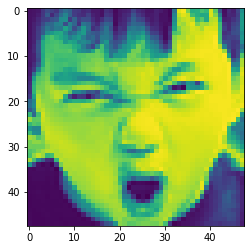

In [39]:
#Test random image from dataset and display it to check that it has formed an image.
plt.imshow(X[25000,:,:,0])

In [40]:
#Identity Block

def identity(X, f, filters, stage, block):
    conv_name_base='res' + str(stage) + block + '_branch'
    bn_name_base='bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv2D(filters=F2, kernel_size=(1, 1), strides=(1, 1), padding='same', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [41]:
#Convolutional Block

def convolutional (X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [42]:
#ResNet50 Block

def ResNet50(input_shape=(48,48,3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model


In [43]:
resnet = ResNet50(input_shape=(48,48,1))

In [44]:
#Add fully connected layers for I/O to ResNet model.
newModel = resnet.output
newModel = Flatten()(newModel)
#Removed dense layer 'fc1' to attempt to improve loss and accuracy.
newModel = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(newModel)
newModel = Dense(7,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(newModel)


In [45]:
#Feed input data into model, output into the fully connected layers.
model = Model(inputs=resnet.input, outputs=newModel)


In [46]:
#Load weights from training, define learning rate and compile model.
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
#Summary of model's layers and parameters.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 54, 54, 1)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 24, 24, 64)   3200        ['zero_padding2d_1[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1[0][0]']            

In [47]:
#Hot encode the emotion labels before training.
y_train = to_categorical(Y_train, num_classes=7)
y_test = to_categorical(Y_test, num_classes=7)


In [48]:
#Define what each result from the prediction function means for each emotion.
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
#Prediction function, returns the vector of image label, as well as index of image location.
preds = model.predict(X_train)
def get_class(preds):
  pred_class = np.zeros((preds.shape[0],1))

  for i in range(len(preds)):
   pred_class[i] = np.argmax(preds[i])

  return pred_class

pred_class_train = get_class(preds)

2022-04-22 04:19:41.441281: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1043804160 exceeds 10% of free system memory.


In [49]:
#Training the model, using batch size of 16 and 50 1000-step epochs, ONLY USED TO TRAIN MODEL.

#Early Stopping to prevent Overfitting the model.
#es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
#Create a checkpoint of the epoch with the highest accuracy.
#mc = ModelCheckpoint('best_model3.h5', monitor='val_accuracy', mode='max')

#Model_Result must remain commented to prevent retraining and overwriting checkpoints after training!

#Model_Result = model.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=50,steps_per_epoch=1000,batch_size=16,verbose=1,callbacks=[mc,es])

#Save the overall model so it can be loaded without having to re-train each time.

#model.save('ResNet-HardCode3')



In [50]:
#Load the saved model, this includes the training weights.
model = load_model('ResNet-HardCode3')

There are 7178 images in the testing folder


/home/vscode/.local/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The predicted emotion is : Happiness


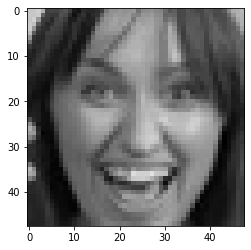

In [51]:
#Pick a random image from the RandomImages folder, containing all test images from FER2013, not from CSV data.
test_image_count = len(os.listdir('/com.docker.devenvironments.code/fer2013/RandomImages'))
print('There are ' + str(test_image_count) + ' images in the testing folder')
test_image = random.choice(os.listdir('/com.docker.devenvironments.code/fer2013/RandomImages'))

img_path = ('/com.docker.devenvironments.code/fer2013/RandomImages/' + test_image)
#Load the selected image
img = image.load_img(img_path, grayscale=True, target_size=(48,48,1))

#Translate image into array form so it can be fed into the prediction function.
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
prediction = np.argmax(model.predict(x))

#Display the image and the predicted emotion as an output.
print('The predicted emotion is : ' + label_dict[prediction])
my_image = image.load_img(img_path)
plt.imshow(my_image)

In [52]:
#Evaluate on Test Data, quickly runs a batch of data through the model to test accuracy and loss:
results = model.evaluate(X_test, y_test, batch_size = 256)
print("test loss, test acc",results)

25/25 [==============================] - 18s 634ms/step - loss: 0.9203 - accuracy: 0.7659
test loss, test acc [0.9203492403030396, 0.7659304141998291]


In [54]:
#Plot graphs for accuracy and loss, can ONLY be done in the same execution as training since Model_Result doesnt save.
#plt.subplot(2,1,1)
#plt.plot(Model_Result.history['accuracy'])
#plt.plot(Model_Result.history['val_accuracy'])
#plt.title('Manual ResNet CSV Model 2nd Fix - Accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc = 'lower right')

In [55]:
#plt.subplot(2,1,2)
#plt.plot(Model_Result.history['loss'])
#plt.plot(Model_Result.history['val_loss'])
#plt.title('Manual ResNet CSV Model 2nd Fix - Loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc = 'upper right')